In [ ]:
# --- 1. Library Installation ---
# Geopandas for maps, hdbscan for clustering, networkx for graphs
!pip install geopandas hdbscan networkx

# --- 2. Import Modules ---
import pandas as pd
import numpy as np
import glob
from google.colab import drive

# Geospatial Modules
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns # Added for the final scatterplot

# Network and Diversity Modules
import networkx as nx
from scipy.stats import entropy

# Machine Learning Modules
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 3. Connect to Google Drive ---
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [ ]:
# ==========================================
# 1. SETUP & DATA LOADING (PORTABLE VERSION)
# ==========================================

# 1.1 Install Libraries
!pip install geopandas hdbscan networkx matplotlib seaborn

# 1.2 Imports
import pandas as pd
import numpy as np
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# ❌ NO MOUNT DRIVE (Not needed for submission)
# from google.colab import drive
# drive.mount('/content/drive')

# ==========================================
# ⚠️ CONFIGURATION: RELATIVE PATHS
# ==========================================
# El código buscará una carpeta llamada 'datasets' subida al entorno de Colab

# Opción A: Si suben la carpeta 'datasets' tal cual a Colab
BASE_PATH = './datasets'

# Rutas construidas automáticamente
PATH_MOVILIDAD_CSVS = f'{BASE_PATH}/mobility_data/*.csv'
PATH_MAPA_GEOJSON   = f'{BASE_PATH}/barris.geojson'
PATH_BUS_CSV        = f'{BASE_PATH}/ESTACIONS_BUS.csv'
PATH_TRANSPORTS_CSV = f'{BASE_PATH}/TRANSPORTS.csv'

# Constants
COL_TRIPS = 'viajes'
COL_ORIGIN = 'barrio_origen_name'
COL_DEST = 'barrio_destino_name'
MAP_COL_NAME = 'n_barri'

# --- VERIFICACIÓN DE ARCHIVOS ---
print(f"Checking files in {BASE_PATH}...")
if not os.path.exists(BASE_PATH):
    print(f"⚠️ WARNING: Folder '{BASE_PATH}' not found.")
    print("INSTRUCTIONS FOR EVALUATOR:")
    print("1. Please upload the 'datasets' folder to the Colab Files area (left panel).")
    print("2. Or adjust 'BASE_PATH' if your folder has a different name.")
else:
    print("✅ 'datasets' folder detected.")

# --- LOAD MOBILITY DATA ---
print(f"Searching for files in: {PATH_MOVILIDAD_CSVS}")
file_paths = glob.glob(PATH_MOVILIDAD_CSVS)
file_paths.sort()

all_dataframes = []
for file in file_paths:
    try:
        df_chunk = pd.read_csv(file)
        # Basic Cleaning
        df_chunk[COL_TRIPS] = df_chunk[COL_TRIPS].where(df_chunk[COL_TRIPS] >= 15, 0)
        df_chunk = df_chunk[df_chunk[COL_TRIPS] > 0]
        df_chunk = df_chunk[df_chunk[COL_ORIGIN] != df_chunk[COL_DEST]]
        all_dataframes.append(df_chunk)
    except Exception as e:
        print(f"Error reading {file}: {e}")

if all_dataframes:
    df = pd.concat(all_dataframes, ignore_index=True)
    print(f"✅ DATA LOADED: {len(df)} rows.")
else:
    print("❌ ERROR: No data loaded. Please upload the 'datasets' folder.")

# --- LOAD GEO MAP ---
try:
    gdf_barrios = gpd.read_file(PATH_MAPA_GEOJSON)
    # Name correction
    gdf_barrios[MAP_COL_NAME] = gdf_barrios[MAP_COL_NAME].replace('el Poble Sec', 'el Poble-sec')
    # Project to Meters (EPSG:25831)
    gdf_barrios = gdf_barrios.to_crs(epsg=25831)
    gdf_barrios['centroid'] = gdf_barrios.geometry.centroid

    # Centroids DataFrame
    df_centroids = gdf_barrios[[MAP_COL_NAME, 'centroid']].copy().set_index(MAP_COL_NAME)
    print(f"✅ MAP LOADED: {len(gdf_barrios)} neighborhoods.")
except Exception as e:
    print(f"❌ ERROR loading map: {e}")

Checking files in ./datasets...
✅ 'datasets' folder detected.
Searching for files in: ./datasets/mobility_data/*.csv
✅ DATA LOADED: 9525818 rows.
✅ MAP LOADED: 73 neighborhoods.


Filtering DataFrame for context: Residente, Weekdays
Aggregating total trips per Origin-Destination pair...
Aggregated DataFrame created with 5248 unique routes.


,barrio_origen_name,barrio_destino_name,viajes_total
0,Baró de Viver,Can Baró,140
1,Baró de Viver,Can Peguera,619
2,Baró de Viver,Canyelles,2567
3,Baró de Viver,Ciutat Meridiana,17057
4,Baró de Viver,Diagonal Mar i el Front Marítim del Poblenou,3444


Joining centroids and calculating distances...
Calculating Network, Volume, Diversity, and Sustainability features...


/tmp/ipython-input-2812230075.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_dist_out_res = df_agg_geo_res.groupby(COL_BARRIO_ORIGEN).apply(weighted_avg_dist).rename('avg_distance_out')
/tmp/ipython-input-2812230075.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_dist_in_res = df_agg_geo_res.groupby(COL_BARRIO_DESTINO).apply(weighted_avg_dist).rename('avg_distance_in')


✅ Residents Dataset enriched! Dimensions: (73, 10)
Scaling and Clustering (K=5)...
Silhouette Score (Residents): 0.3085
Generating Residents Map...


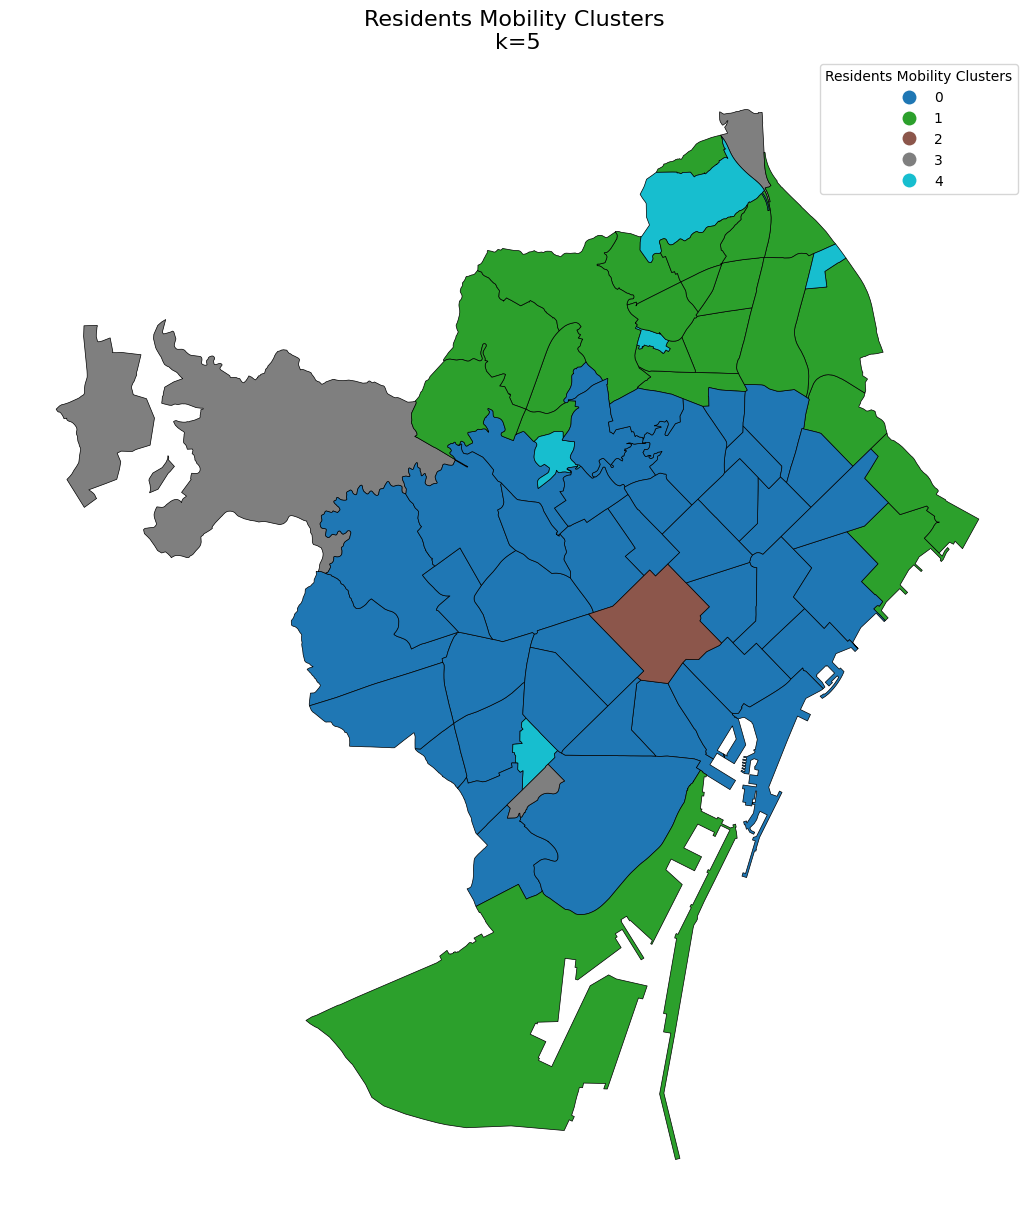

--- Residents Cluster Profiles (Mean Values) ---


,out_total_viajes,in_total_viajes,n_unique_destinations,n_unique_origins,pagerank,entropy_out,entropy_in,avg_distance_out,avg_distance_in,net_flow
cluster_kmeans,,,,,,,,,,
0,1.433424e+07,1.440026e+07,72.000000,72.000000,0.016242,3.652113,3.647918,3.008502,3.008016,6.601305e+04
1,6.279906e+06,6.281357e+06,72.000000,72.000000,0.008895,3.815437,3.808260,4.047391,4.018518,1.451500e+03
2,8.991161e+07,8.685139e+07,72.000000,72.000000,0.090119,3.915144,3.933987,2.824048,2.856648,-3.060220e+06
3,1.778739e+06,1.738672e+06,71.333333,69.666667,0.003689,3.207520,3.100126,4.278677,4.121818,-4.006733e+04
4,2.052266e+06,2.127454e+06,70.800000,71.800000,0.004189,3.550335,3.549839,3.054658,3.135344,7.518820e+04


In [ ]:
# ==========================================
# PHASE 1: RESIDENTS ANALYSIS
# ==========================================

# --- 1. Filter by Context (Residents, Weekdays) ---
FILTRO_ORIGEN = 'Residente'
FILTRO_DIAS_LABORABLES = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes']

print(f"Filtering DataFrame for context: {FILTRO_ORIGEN}, Weekdays")
df_res = df[
    (df['origen'] == FILTRO_ORIGEN) &
    (df['day_of_week'].isin(FILTRO_DIAS_LABORABLES))
].copy()

# --- 2. Aggregate Trips ---
print("Aggregating total trips per Origin-Destination pair...")
df_agg_res = df_res.groupby([COL_BARRIO_ORIGEN, COL_BARRIO_DESTINO]).agg(
    viajes_total=('viajes', 'sum')
).reset_index()

print(f"Aggregated DataFrame created with {len(df_agg_res)} unique routes.")
display(df_agg_res.head())

# --- 3. Geometry & Distances ---
print("Joining centroids and calculating distances...")
df_agg_geo_res = df_agg_res.merge(df_centroids, left_on=COL_BARRIO_ORIGEN, right_index=True).rename(columns={'centroid': 'geom_origen'})
df_agg_geo_res = df_agg_geo_res.merge(df_centroids, left_on=COL_BARRIO_DESTINO, right_index=True).rename(columns={'centroid': 'geom_destino'})

df_agg_geo_res['distancia_m'] = df_agg_geo_res.apply(lambda row: row['geom_origen'].distance(row['geom_destino']), axis=1)
df_agg_geo_res['distancia_km'] = df_agg_geo_res['distancia_m'] / 1000

# --- 4. Feature Engineering ---
print("Calculating Network, Volume, Diversity, and Sustainability features...")
nodos_unicos_res = sorted(list(set(df_agg_geo_res[COL_BARRIO_ORIGEN]) | set(df_agg_geo_res[COL_BARRIO_DESTINO])))

# NetworkX Graph
G_res = nx.from_pandas_edgelist(df_agg_geo_res, COL_BARRIO_ORIGEN, COL_BARRIO_DESTINO, ['viajes_total', 'distancia_km'], create_using=nx.DiGraph())
pagerank_res = pd.Series(nx.pagerank(G_res, weight='viajes_total'), name='pagerank')

# Volume
out_total_res = df_agg_geo_res.groupby(COL_BARRIO_ORIGEN)['viajes_total'].sum().rename('out_total_viajes')
in_total_res = df_agg_geo_res.groupby(COL_BARRIO_DESTINO)['viajes_total'].sum().rename('in_total_viajes')
out_unique_res = df_agg_geo_res.groupby(COL_BARRIO_ORIGEN)[COL_BARRIO_DESTINO].nunique().rename('n_unique_destinations')
in_unique_res = df_agg_geo_res.groupby(COL_BARRIO_DESTINO)[COL_BARRIO_ORIGEN].nunique().rename('n_unique_origins')

# Diversity (Entropy)
def calculate_entropy(group):
    p = group.values / group.sum()
    return entropy(p)

entropy_out_res = df_agg_geo_res.groupby(COL_BARRIO_ORIGEN)['viajes_total'].apply(calculate_entropy).rename('entropy_out')
entropy_in_res = df_agg_geo_res.groupby(COL_BARRIO_DESTINO)['viajes_total'].apply(calculate_entropy).rename('entropy_in')

# Sustainability (Weighted Distance)
def weighted_avg_dist(group):
    return np.average(group['distancia_km'], weights=group['viajes_total'])

avg_dist_out_res = df_agg_geo_res.groupby(COL_BARRIO_ORIGEN).apply(weighted_avg_dist).rename('avg_distance_out')
avg_dist_in_res = df_agg_geo_res.groupby(COL_BARRIO_DESTINO).apply(weighted_avg_dist).rename('avg_distance_in')

# Assembly
features_res = pd.DataFrame(index=nodos_unicos_res)
all_features_res = [out_total_res, in_total_res, out_unique_res, in_unique_res, pagerank_res, entropy_out_res, entropy_in_res, avg_dist_out_res, avg_dist_in_res]

for feature in all_features_res:
    features_res = features_res.merge(feature, left_index=True, right_index=True, how='left')

features_res['net_flow'] = features_res['in_total_viajes'] - features_res['out_total_viajes']
features_res = features_res.fillna(0)

print(f"✅ Residents Dataset enriched! Dimensions: {features_res.shape}")

# --- 5. Clustering (KMeans) ---
print("Scaling and Clustering (K=5)...")
scaler = StandardScaler()
X_scaled_res = scaler.fit_transform(features_res)

kmeans_res = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_res = kmeans_res.fit_predict(X_scaled_res)
features_res['cluster_kmeans'] = labels_res

sil_score_res = silhouette_score(X_scaled_res, labels_res)
print(f"Silhouette Score (Residents): {sil_score_res:.4f}")

# --- 6. Visualization ---
print("Generating Residents Map...")
mapa_clusters_res = gdf_barrios.merge(features_res, left_on=MAP_COL_NAME, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
mapa_clusters_res.plot(column='cluster_kmeans', ax=ax, categorical=True, legend=True, legend_kwds={'title': "Residents Mobility Clusters"}, cmap='tab10', edgecolor='black', linewidth=0.5)
ax.set_title(f'Residents Mobility Clusters \nk=5', fontsize=16)
ax.set_axis_off()
plt.show()

# Display Profiles
print("--- Residents Cluster Profiles (Mean Values) ---")
display(features_res.groupby('cluster_kmeans').mean())

Filtering DataFrame for context: Internacional (All days)
Aggregating total trips per Origin-Destination pair...
Aggregated DataFrame created with 3844 unique routes.


,barrio_origen_name,barrio_destino_name,viajes_total
0,Baró de Viver,Diagonal Mar i el Front Marítim del Poblenou,105
1,Baró de Viver,Horta,100
2,Baró de Viver,Hostafrancs,16
3,Baró de Viver,Montbau,48
4,Baró de Viver,Porta,213


Joining centroids and calculating distances...
Calculating Network, Volume, Diversity, and Sustainability features...


/tmp/ipython-input-4047931994.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_dist_out_tour = df_agg_geo_tour.groupby(COL_BARRIO_ORIGEN).apply(weighted_avg_dist).rename('avg_distance_out')
/tmp/ipython-input-4047931994.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_dist_in_tour = df_agg_geo_tour.groupby(COL_BARRIO_DESTINO).apply(weighted_avg_dist).rename('avg_distance_in')


✅ Tourists Dataset enriched! Dimensions: (72, 10)
Scaling and Clustering (K=5)...
Silhouette Score (Tourists): 0.3319
Generating Tourists Map...


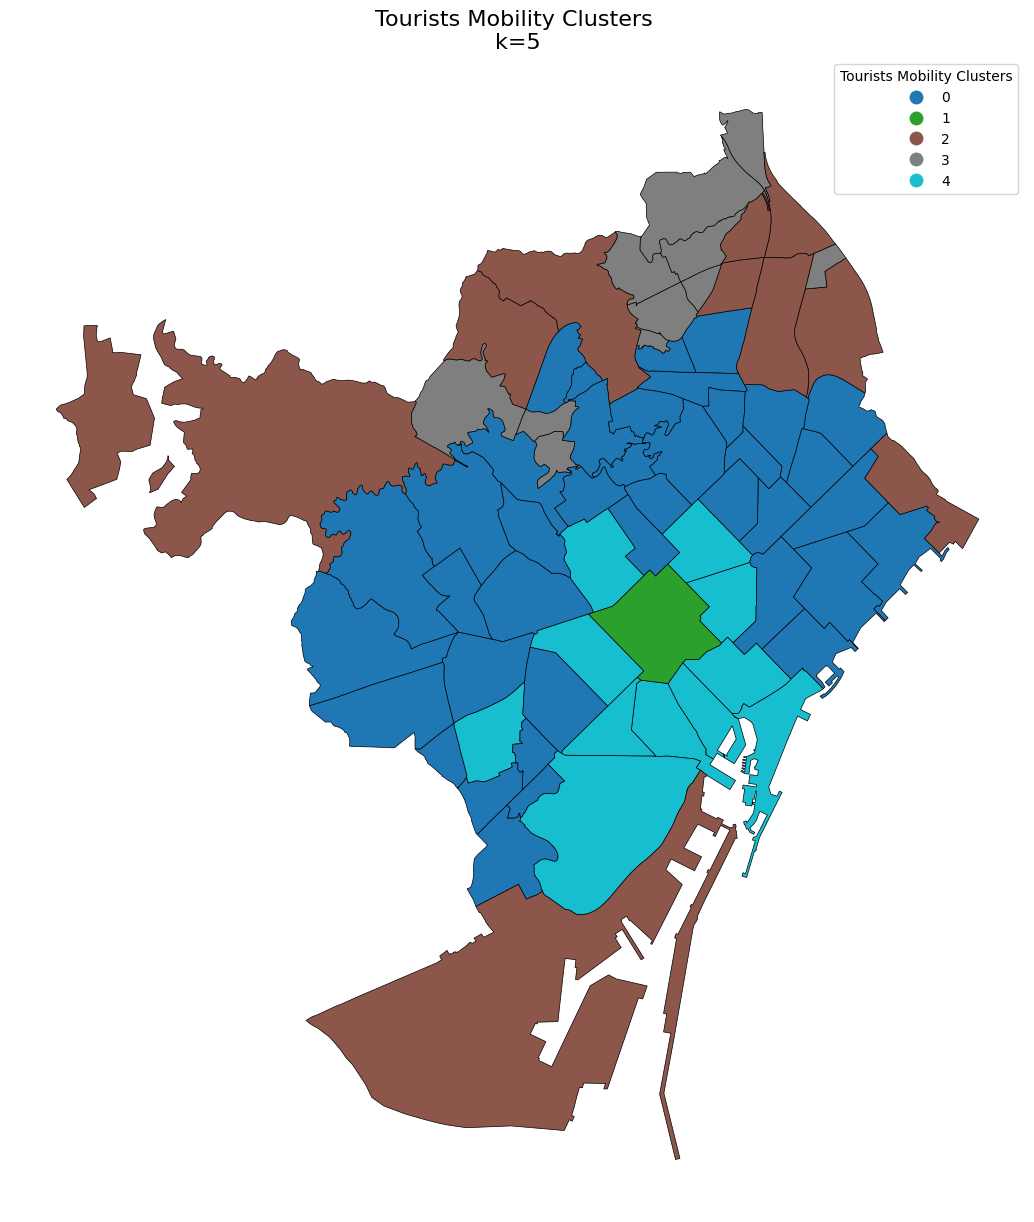

--- Tourists Cluster Profiles (Mean Values) ---


,out_total_viajes,in_total_viajes,n_unique_destinations,n_unique_origins,pagerank,entropy_out,entropy_in,avg_distance_out,avg_distance_in,net_flow
cluster_kmeans,,,,,,,,,,
0,2.633317e+06,2.626746e+06,56.666667,56.897436,0.008028,2.930311,2.945576,2.902733,2.911252,-6.571462e+03
1,7.219364e+07,6.964442e+07,70.000000,70.000000,0.162225,3.211143,3.265520,2.207876,2.241185,-2.549229e+06
2,1.758842e+06,1.790506e+06,57.900000,58.500000,0.006773,3.035028,2.907757,5.009974,4.994747,3.166320e+04
3,2.588336e+04,2.447245e+04,24.181818,22.181818,0.002167,1.526225,1.422390,3.974622,3.618021,-1.408182e+03
4,1.781426e+07,1.804193e+07,65.363636,66.000000,0.039373,2.907590,2.887046,2.290900,2.283447,2.276731e+05


In [ ]:
# ==========================================
# PHASE 2: TOURISTS ANALYSIS
# ==========================================

# --- 1. Filter by Context (International) ---
FILTRO_ORIGEN = 'Internacional'

print(f"Filtering DataFrame for context: {FILTRO_ORIGEN} (All days)")
df_tour = df[
    (df['origen'] == FILTRO_ORIGEN)
].copy()

# --- 2. Aggregate Trips ---
print("Aggregating total trips per Origin-Destination pair...")
df_agg_tour = df_tour.groupby([COL_BARRIO_ORIGEN, COL_BARRIO_DESTINO]).agg(
    viajes_total=('viajes', 'sum')
).reset_index()

print(f"Aggregated DataFrame created with {len(df_agg_tour)} unique routes.")
display(df_agg_tour.head())

# --- 3. Geometry & Distances ---
print("Joining centroids and calculating distances...")
df_agg_geo_tour = df_agg_tour.merge(df_centroids, left_on=COL_BARRIO_ORIGEN, right_index=True).rename(columns={'centroid': 'geom_origen'})
df_agg_geo_tour = df_agg_geo_tour.merge(df_centroids, left_on=COL_BARRIO_DESTINO, right_index=True).rename(columns={'centroid': 'geom_destino'})

df_agg_geo_tour['distancia_m'] = df_agg_geo_tour.apply(lambda row: row['geom_origen'].distance(row['geom_destino']), axis=1)
df_agg_geo_tour['distancia_km'] = df_agg_geo_tour['distancia_m'] / 1000

# --- 4. Feature Engineering ---
print("Calculating Network, Volume, Diversity, and Sustainability features...")
nodos_unicos_tour = sorted(list(set(df_agg_geo_tour[COL_BARRIO_ORIGEN]) | set(df_agg_geo_tour[COL_BARRIO_DESTINO])))

# NetworkX Graph
G_tour = nx.from_pandas_edgelist(df_agg_geo_tour, COL_BARRIO_ORIGEN, COL_BARRIO_DESTINO, ['viajes_total', 'distancia_km'], create_using=nx.DiGraph())
pagerank_tour = pd.Series(nx.pagerank(G_tour, weight='viajes_total'), name='pagerank')

# Volume
out_total_tour = df_agg_geo_tour.groupby(COL_BARRIO_ORIGEN)['viajes_total'].sum().rename('out_total_viajes')
in_total_tour = df_agg_geo_tour.groupby(COL_BARRIO_DESTINO)['viajes_total'].sum().rename('in_total_viajes')
out_unique_tour = df_agg_geo_tour.groupby(COL_BARRIO_ORIGEN)[COL_BARRIO_DESTINO].nunique().rename('n_unique_destinations')
in_unique_tour = df_agg_geo_tour.groupby(COL_BARRIO_DESTINO)[COL_BARRIO_ORIGEN].nunique().rename('n_unique_origins')

# Diversity (Entropy) - using same function as before
entropy_out_tour = df_agg_geo_tour.groupby(COL_BARRIO_ORIGEN)['viajes_total'].apply(calculate_entropy).rename('entropy_out')
entropy_in_tour = df_agg_geo_tour.groupby(COL_BARRIO_DESTINO)['viajes_total'].apply(calculate_entropy).rename('entropy_in')

# Sustainability - using same function as before
avg_dist_out_tour = df_agg_geo_tour.groupby(COL_BARRIO_ORIGEN).apply(weighted_avg_dist).rename('avg_distance_out')
avg_dist_in_tour = df_agg_geo_tour.groupby(COL_BARRIO_DESTINO).apply(weighted_avg_dist).rename('avg_distance_in')

# Assembly
features_tour = pd.DataFrame(index=nodos_unicos_tour)
all_features_tour = [out_total_tour, in_total_tour, out_unique_tour, in_unique_tour, pagerank_tour, entropy_out_tour, entropy_in_tour, avg_dist_out_tour, avg_dist_in_tour]

for feature in all_features_tour:
    features_tour = features_tour.merge(feature, left_index=True, right_index=True, how='left')

features_tour['net_flow'] = features_tour['in_total_viajes'] - features_tour['out_total_viajes']
features_tour = features_tour.fillna(0)

print(f"✅ Tourists Dataset enriched! Dimensions: {features_tour.shape}")

# --- 5. Clustering (KMeans) ---
print("Scaling and Clustering (K=5)...")
scaler_tour = StandardScaler()
X_scaled_tour = scaler_tour.fit_transform(features_tour)

kmeans_tour = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_tour = kmeans_tour.fit_predict(X_scaled_tour)
features_tour['cluster_kmeans'] = labels_tour

sil_score_tour = silhouette_score(X_scaled_tour, labels_tour)
print(f"Silhouette Score (Tourists): {sil_score_tour:.4f}")

# --- 6. Visualization ---
print("Generating Tourists Map...")
mapa_clusters_tour = gdf_barrios.merge(features_tour, left_on=MAP_COL_NAME, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
mapa_clusters_tour.plot(column='cluster_kmeans', ax=ax, categorical=True, legend=True, legend_kwds={'title': "Tourists Mobility Clusters"}, cmap='tab10', edgecolor='black', linewidth=0.5)
ax.set_title(f'Tourists Mobility Clusters \nk=5', fontsize=16)
ax.set_axis_off()
plt.show()

# Display Profiles
print("--- Tourists Cluster Profiles (Mean Values) ---")
display(features_tour.groupby('cluster_kmeans').mean())

--- 1. Loading Supply Datasets ---
Buses loaded: 3226 stops.
Transports loaded: 684 stations.
Filtered Transports (Metro/Renfe/FGC...): 637
Total public transport points: 3856
Performing spatial join (stops within neighborhoods)...

✅ Supply calculated!


,num_paradas_tmb
n_barri,
la Dreta de l'Eixample,184
el Poble-sec,143
la Marina del Prat Vermell,127
Sant Gervasi - Galvany,100
l'Antiga Esquerra de l'Eixample,95
Sant Andreu,91
Sarrià,85
Sant Gervasi - la Bonanova,83
el Guinardó,82


--- Top 5 Neighborhoods with HIGHEST Tourist Pressure on TMB ---


,presion_tmb
"Vallvidrera, el Tibidabo i les Planes",inf
el Barri Gòtic,9.561782e+05
"Sant Pere, Santa Caterina i la Ribera",5.122333e+05
el Raval,4.316100e+05
la Sagrada Família,4.064088e+05


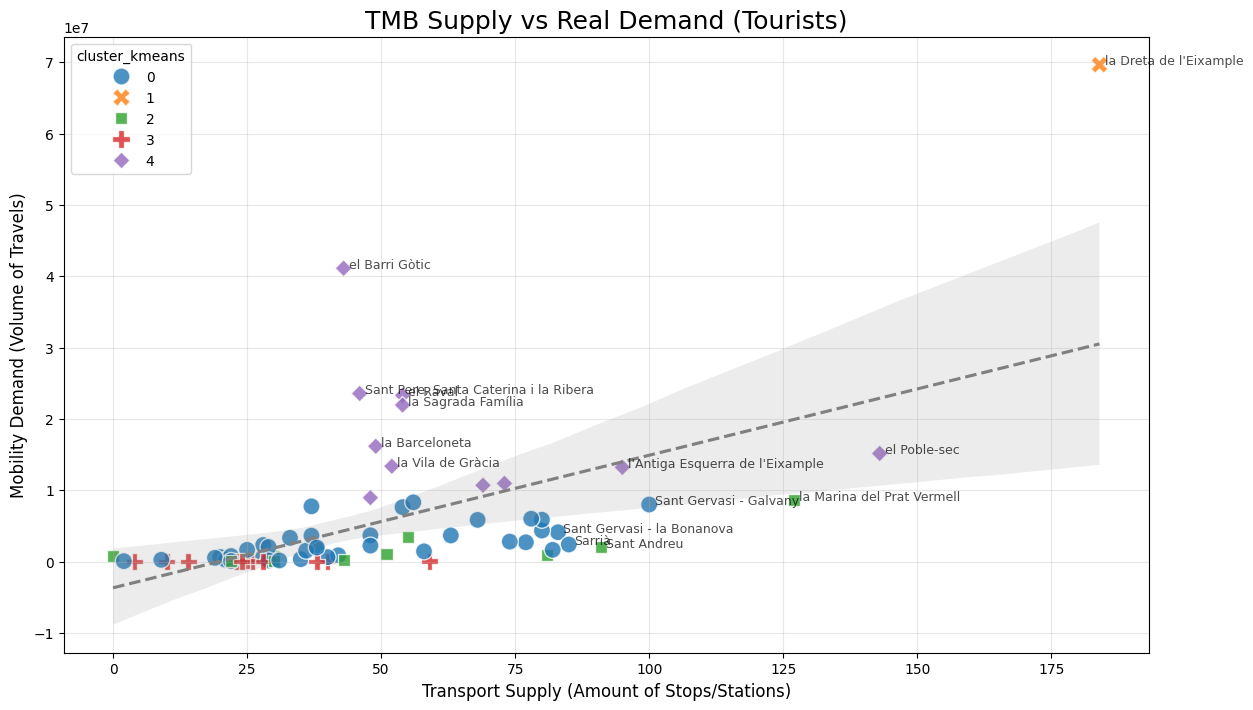

In [ ]:
# ==========================================
# PHASE 3: TRANSPORT SUPPLY VS DEMAND
# ==========================================

# 1. Routes to your datasets
PATH_BUS = '/content/drive/MyDrive/Cuarto/ProjectManagement/proyecto_ML/datasets/ESTACIONS_BUS.csv'
PATH_TRANSPORTS = '/content/drive/MyDrive/Cuarto/ProjectManagement/proyecto_ML/datasets/TRANSPORTS.csv'

print("--- 1. Loading Supply Datasets ---")
try:
    # Load CSVs
    df_bus = pd.read_csv(PATH_BUS, sep=',')
    df_transports = pd.read_csv(PATH_TRANSPORTS, sep=',')

    print(f"Buses loaded: {len(df_bus)} stops.")
    print(f"Transports loaded: {len(df_transports)} stations.")

    # --- 2. Smart Filtering ---

    # A) BUSES: Keep Day and Night
    df_bus_clean = df_bus[
        df_bus['NOM_CAPA'].str.contains('Autobusos', case=False, na=False)
    ].copy()

    # B) TRANSPORTS: Keep Metro, FGC, Renfe, Tram
    # Exclude: Teleferic, Funicular, Tramvia Blau (Touristic/Special)
    keywords_keep = ['Metro', 'FGC', 'Renfe', 'Rodalies', 'Tramvia', 'Tren']
    keywords_exclude = ['Telefèric', 'Funicular', 'Blau', 'Aeri']

    def is_valid_transport(name):
        name = str(name)
        if any(bad in name for bad in keywords_exclude): return False
        if any(good in name for good in keywords_keep): return True
        return False

    df_transports_clean = df_transports[
        df_transports['NOM_CAPA'].apply(is_valid_transport)
    ].copy()

    print(f"Filtered Transports (Metro/Renfe/FGC...): {len(df_transports_clean)}")

    # Merge datasets
    df_supply_total = pd.concat([df_bus_clean, df_transports_clean], ignore_index=True)
    print(f"Total public transport points: {len(df_supply_total)}")

    # --- 3. Georeferencing ---
    gdf_supply = gpd.GeoDataFrame(
        df_supply_total,
        geometry=gpd.points_from_xy(df_supply_total.LONGITUD, df_supply_total.LATITUD),
        crs="EPSG:4326" # Original GPS coordinates
    )

    # Reproject to match neighborhood map (EPSG:25831)
    gdf_supply = gdf_supply.to_crs(gdf_barrios.crs)

    # --- 4. Spatial Join ---
    print("Performing spatial join (stops within neighborhoods)...")
    stops_in_barrios = gpd.sjoin(
        gdf_supply,
        gdf_barrios[[MAP_COL_NAME, 'geometry']],
        how="inner",
        predicate="within"
    )

    # --- 5. Final Count ---
    supply_per_barrio = stops_in_barrios.groupby(MAP_COL_NAME).size().rename('num_paradas_tmb')
    print("\n✅ Supply calculated!")
    display(supply_per_barrio.sort_values(ascending=False).head(10))

    # --- CROSSING SUPPLY VS TOURIST DEMAND ---

    # We use 'features_tour' (The Tourist Dataset calculated in the previous cell)
    df_final = features_tour.copy()

    # Add supply column
    df_final = df_final.merge(supply_per_barrio, left_index=True, right_index=True, how='left')
    df_final['num_paradas_tmb'] = df_final['num_paradas_tmb'].fillna(0)

    # Calculate "Pressure" Indicator (Trips per Available Stop)
    df_final['presion_tmb'] = df_final['in_total_viajes'] / df_final['num_paradas_tmb']

    print("--- Top 5 Neighborhoods with HIGHEST Tourist Pressure on TMB ---")
    display(df_final['presion_tmb'].sort_values(ascending=False).head(5))

    # --- VISUALIZATION: Scatter Plot ---
    plt.figure(figsize=(14, 8))

    sns.scatterplot(
        data=df_final,
        x='num_paradas_tmb',      # X Axis: Supply
        y='in_total_viajes',      # Y Axis: Demand (Tourists)
        hue='cluster_kmeans',     # Color
        style='cluster_kmeans',   # Shape
        palette='tab10',
        s=150,
        alpha=0.8
    )

    # Smart Labels (only extremes)
    threshold_trips = df_final['in_total_viajes'].quantile(0.90)
    threshold_stops = df_final['num_paradas_tmb'].quantile(0.90)

    for barrio, row in df_final.iterrows():
        if row['in_total_viajes'] > threshold_trips or row['num_paradas_tmb'] > threshold_stops:
            plt.text(
                row['num_paradas_tmb']+1,
                row['in_total_viajes'],
                barrio,
                fontsize=9,
                alpha=0.7
            )

    # Trend Line
    sns.regplot(
        data=df_final,
        x='num_paradas_tmb',
        y='in_total_viajes',
        scatter=False,
        color='grey',
        line_kws={'linestyle':'--'}
    )
    plt.title('TMB Supply vs Real Demand (Tourists)', fontsize=18)
    plt.xlabel('Transport Supply (Amount of Stops/Stations)', fontsize=12)
    plt.ylabel('Mobility Demand (Volume of Travels)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"❌ Error in Supply/Demand process: {e}")


--- INTEGRATING DATA: RESIDENTS + TOURISTS + SUPPLY ---
✅ Data Integrated. Showing top 5 neighborhoods by Total Demand:


,viajes_res,viajes_tur,total_demand_M,num_paradas_tmb,type
n_barri,,,,,
la Dreta de l'Eixample,86851394,69644415.0,156.495809,184.0,Tourist Zone (>40%)
el Barri Gòtic,19006387,41115661.0,60.122048,43.0,Tourist Zone (>40%)
la Vila de Gràcia,32892428,13366901.0,46.259329,52.0,Mixed Zone (20-40%)
la Sagrada Família,23647200,21946075.0,45.593275,54.0,Tourist Zone (>40%)
el Raval,21514244,23306942.0,44.821186,54.0,Tourist Zone (>40%)


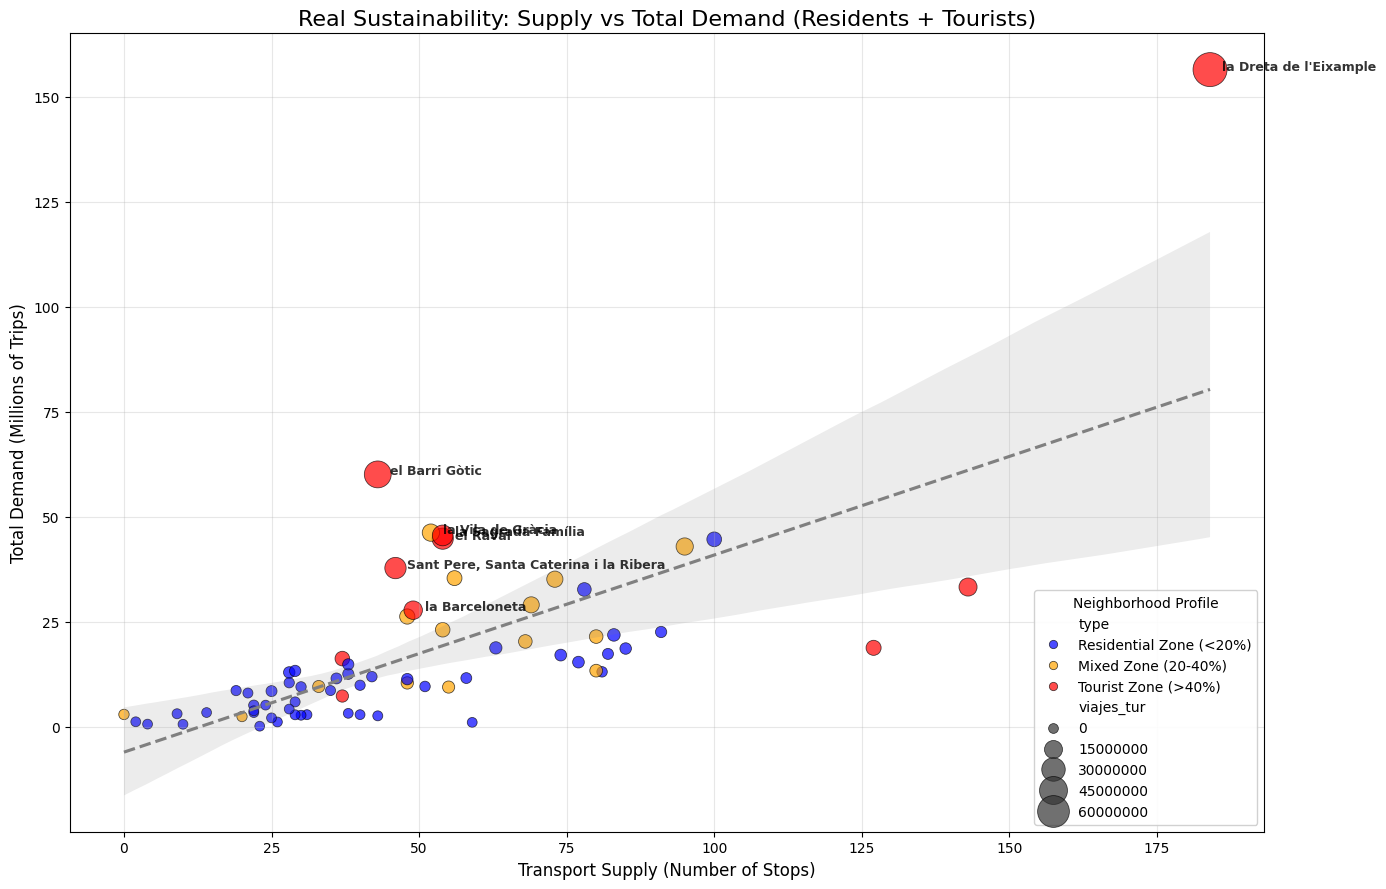

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==========================================
# PHASE 4: TOTAL SUSTAINABILITY ANALYSIS
# ==========================================

print("\n--- INTEGRATING DATA: RESIDENTS + TOURISTS + SUPPLY ---")

# 1. Prepare Final DataFrame using the map index as base
df_total = pd.DataFrame(index=gdf_barrios[MAP_COL_NAME])

# 2. Retrieve Resident Demand (Inflow)
try:
    df_total['viajes_res'] = features_res['in_total_viajes']
except NameError:
    print("⚠️ 'features_res' not found. Make sure you ran Cell 3.")
    df_total['viajes_res'] = 0

# 3. Retrieve Tourist Demand (Inflow)
try:
    df_total['viajes_tur'] = features_tour['in_total_viajes']
except NameError:
    print("⚠️ 'features_tour' not found. Make sure you ran Cell 4.")
    df_total['viajes_tur'] = 0

# 4. Retrieve Supply from Cell 5
try:
    df_total = df_total.merge(supply_per_barrio, left_index=True, right_index=True, how='left')
    df_total['num_paradas_tmb'] = df_total['num_paradas_tmb'].fillna(0)
except NameError:
    print("⚠️ 'supply_per_barrio' not found. Make sure you ran Cell 5.")
    df_total['num_paradas_tmb'] = 0


# 5. Calculations
# Total Demand
df_total['total_demand'] = df_total['viajes_res'].fillna(0) + df_total['viajes_tur'].fillna(0)

# --- CONVERTIR A MILLONES ---
df_total['total_demand_M'] = df_total['total_demand'] / 1_000_000
# -----------------------------

# Tourist Ratio (% of tourists)
df_total['tourist_ratio'] = df_total['viajes_tur'] / df_total['total_demand']

# Classification Logic
def classify_hood(r):
    if r > 0.40: return 'Tourist Zone (>40%)'
    if r > 0.20: return 'Mixed Zone (20-40%)'
    return 'Residential Zone (<20%)'

df_total['type'] = df_total['tourist_ratio'].apply(classify_hood)

print("✅ Data Integrated. Showing top 5 neighborhoods by Total Demand:")
display(df_total[['viajes_res', 'viajes_tur', 'total_demand_M', 'num_paradas_tmb', 'type']].sort_values('total_demand_M', ascending=False).head())


# ==========================================
# FINAL VISUALIZATION: SCATTER PLOT
# ==========================================

plt.figure(figsize=(14, 9))

# Scatter Plot
sns.scatterplot(
    data=df_total,
    x='num_paradas_tmb',
    y='total_demand_M',        # Eje Y en Millones
    hue='type',
    size='viajes_tur',
    sizes=(50, 600),
    palette={'Tourist Zone (>40%)': 'red', 'Mixed Zone (20-40%)': 'orange', 'Residential Zone (<20%)': 'blue'},
    alpha=0.7,
    edgecolor='black'
)

# Trend Line (Equilibrium)
sns.regplot(
    data=df_total,
    x='num_paradas_tmb',
    y='total_demand_M',
    scatter=False,
    color='grey',
    line_kws={'linestyle':'--', 'label': 'Avg. Efficiency'}
)

# Smart Labels (Outliers)
top_demand = df_total['total_demand_M'].quantile(0.95)
top_ratio = df_total['tourist_ratio'].quantile(0.95)

for hood, row in df_total.iterrows():
    if row['total_demand_M'] > top_demand or row['tourist_ratio'] > top_ratio:
        plt.text(
            row['num_paradas_tmb']+2,
            row['total_demand_M'],
            hood,
            fontsize=9,
            fontweight='bold',
            alpha=0.8
        )

# Titles
plt.title("Real Sustainability: Supply vs Total Demand (Residents + Tourists)", fontsize=16)
plt.xlabel("Transport Supply (Number of Stops)", fontsize=12)
plt.ylabel("Total Demand (Millions of Trips)", fontsize=12)

plt.grid(True, alpha=0.3)

# --- CAMBIO: LEYENDA ABAJO A LA DERECHA ---
plt.legend(
    loc='lower right',
    title="Neighborhood Profile",
    frameon=True,       # Pone un recuadro blanco para que se lea bien sobre la cuadrícula
    framealpha=0.9
)
# ------------------------------------------

plt.tight_layout()
plt.show()